# **Natural Language Processing for Spam Detection**

---

## **Overview**

This notebook explores the application of Natural Language Processing (NLP) techniques to classify text messages as either spam or legitimate (ham). The goal is to build a machine learning model that can accurately predict whether a given message is spam (unsolicited or promotional) or harmless (non-spam).

## **Dataset**

The dataset used for this analysis consists of labeled text messages, where each message is tagged as either spam or ham. It includes a collection of text features derived from these messages, which will be used to train and evaluate our NLP models.

## **Approach**

We'll follow these main steps:

1. **Data Preprocessing**: Cleaning and preparing the text data for analysis, including tasks such as tokenization, removing stopwords, and vectorization.
   
2. **Model Selection, Training and Evaluation**: Exploring various machine learning algorithms suitable for text classification, such as Naive Bayes, Support Vector Machines (SVM), Random Forest Classifier or XGBoost Classifier. Building and training our models using the preprocessed data, then evaluating their performance in terms of accuracy, precision, recall, and F1-score.
   
3. **Model Deployment**: Deploying the best-performing model to predict the spamminess of new, unseen text messages.

## **Tools and Libraries**

We'll primarily use Python along with popular libraries for NLP and machine learning, including:

- `numpy` and `pandas` for data manipulation
- `nltk` and `scikit-learn` for NLP tasks and machine learning algorithms
- `matplotlib` for visualization

## **Let's Get Started!**

Now, let's dive into the implementation of these steps and develop a robust spam detection model using NLP techniques.

---

# **1. Data Preprocessing** 

In [302]:
# %pip install nltk
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import RegexpTokenizer

In [303]:
data = pd.read_csv("dataset/spam.csv", encoding='latin-1')

In [304]:
# Select only the columns that we need
data = data[['v1', 'v2']]
data.columns = ['label', 'msg']

total_positive_samples = len(data[data['label'] == 'spam'])
total_negative_samples = len(data[data['label'] == 'ham'])

print("Total positive samples: ", total_positive_samples)
print("Total negative samples: ", total_negative_samples)

Total positive samples:  747
Total negative samples:  4825


In [305]:
def preproccess(data):
    """
    This function takes a string and returns a string after removing stopwords and lemmatizing the words.
    Parameters:
    data : str : A string that needs to be preprocessed.
    Returns:
    words : str : A string after removing stopwords and lemmatizing the words.    
    """
    data= data.lower()
    lem = WordNetLemmatizer()
    words = word_tokenize(data)
    words = [word for word in words if word not in stopwords.words("english")]
    words = [lem.lemmatize(word, pos='v') for word in words]
    words = " ".join(words)
    
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(words)
    words = " ".join(words)
    return words

def storeAllWords(list_of_messages):
    """
    This function takes a list of messages and returns a list of all the words in the messages.
    Parameters:
    list_of_messages : list : A list of messages.
    Returns:
    allWords : list : A list of all the words in the messages.
    """
    allWords=[]
    for msg in list_of_messages:
        for word in msg:
            allWords.append(word)
    return allWords


def getMostCommon(list_of_words, index):
    """
    This function takes a list of words and an index and stores the most common words in the global dataframe.
    Parameters:
    list_of_words : list : A list of words.
    index : int : The index of the message.
    """
    global df
    freq=nltk.FreqDist(list_of_words)
    freq=freq.most_common(len(freq))
    for f in freq:
        df[f[0]][index]=f[1]

In [306]:
# Test the preproccess function on a single message

test = data["msg"][100]
preprocessed_test = preproccess(test)

print(f'Test message:\n{test}')
print('-' * 85)
print(f'Preprocessed message:\n{preprocessed_test}')

Test message:
Okay name ur price as long as its legal! Wen can I pick them up? Y u ave x ams xx
-------------------------------------------------------------------------------------
Preprocessed message:
okay name ur price long legal wen pick u ave x ams xx


In [307]:
# Create a new dataframe with all the words in the messages

proc_msgs = {"label":[], "msg":[]}
for i in range(0, len(data["msg"])):
    proc_msgs["msg"].append(preproccess(data["msg"][i]).split())
    proc_msgs["label"].append(data["label"][i])

allwords = storeAllWords(proc_msgs["msg"])
allwords_set = set(allwords)

print(f'Amount of unique words: {len(allwords_set)}')

Amount of unique words: 7740


In [308]:
df = pd.DataFrame(columns=list(allwords_set))
df.insert(0, 'label', proc_msgs["label"])

for i in range(0,len(proc_msgs["msg"])):
    freq=set(proc_msgs["msg"][i])
    getMostCommon(freq,i)

In [309]:
# Fill the NaN values with 0

df=df.fillna(0)
len(df)

5572

# **2. Model Selection, Training and Evaluation**

In [310]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

X = df.drop(["label"], axis=1)
y = df["label"]


# Perform one-hot encoding on the labels
onehot = OneHotEncoder(drop='first')
y = onehot.fit_transform(np.array(y).reshape(-1,1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

-------------------------------------------------------------------------------------
                          GAUSSIAN NAIVE BAYES MODEL
-------------------------------------------------------------------------------------
                            Accuracy score: 87.89%
-------------------------------------------------------------------------------------
Classification report:

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93       965
         1.0       0.53      0.94      0.68       150

    accuracy                           0.88      1115
   macro avg       0.76      0.90      0.80      1115
weighted avg       0.93      0.88      0.89      1115



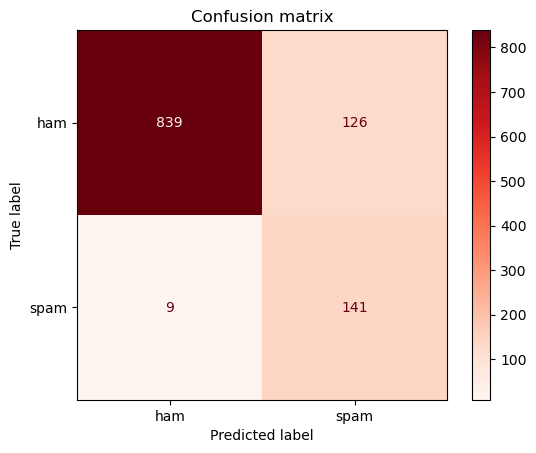

In [267]:
# Train the model using Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB

gauss = GaussianNB()
gauss.fit(X_train, y_train.ravel())
y_pred = gauss.predict(X_test)

print('-' * 85)
print('                          GAUSSIAN NAIVE BAYES MODEL')
print('-' * 85)
print(f'                            Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('-' * 85)
print('Classification report:\n')
print(classification_report(y_test, y_pred))

conf_mtrx = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=onehot.categories_[0])
disp.plot(cmap='Reds')
plt.title('Confusion matrix')
plt.show()

-------------------------------------------------------------------------------------
                        SUPPORT VECTOR MACHINE MODEL
-------------------------------------------------------------------------------------
                            Accuracy score: 98.12%
-------------------------------------------------------------------------------------
Classification report:

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       965
         1.0       1.00      0.86      0.92       150

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.96      1115
weighted avg       0.98      0.98      0.98      1115



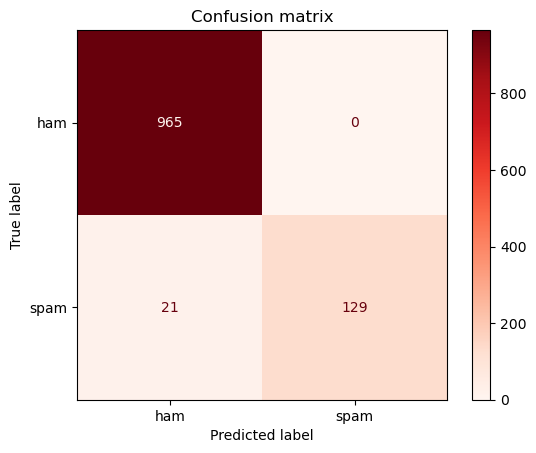

In [279]:
# Train the model using Support Vector Machine
from sklearn.svm import SVC

svc = SVC(kernel='linear', C=1000, random_state=42, probability=True)
svc.fit(X_train, y_train.ravel())
y_pred = svc.predict(X_test)

print('-' * 85)
print('                        SUPPORT VECTOR MACHINE MODEL')
print('-' * 85)
print(f'                            Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('-' * 85)
print('Classification report:\n')
print(classification_report(y_test, y_pred))

conf_mtrx = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=onehot.categories_[0])
disp.plot(cmap='Reds')
plt.title('Confusion matrix')
plt.show()

-------------------------------------------------------------------------------------
                        RANDOM FOREST CLASSIFIER MODEL
-------------------------------------------------------------------------------------
                            Accuracy score: 97.40%
-------------------------------------------------------------------------------------
Classification report:

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99       965
         1.0       1.00      0.81      0.89       150

    accuracy                           0.97      1115
   macro avg       0.99      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



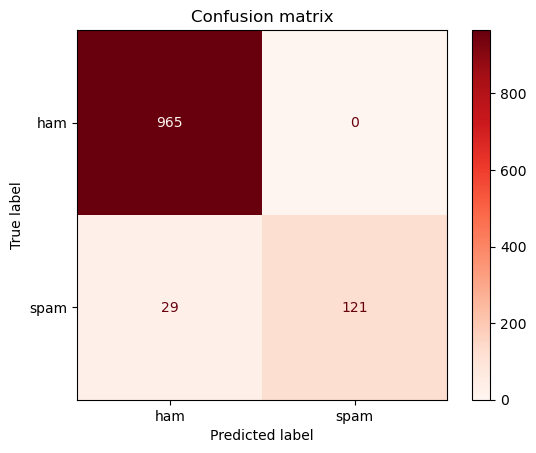

In [297]:
# Train the model using Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, criterion='entropy', bootstrap=True, random_state=42)
rf.fit(X_train, y_train.ravel())
y_pred = rf.predict(X_test)

print('-' * 85)
print('                        RANDOM FOREST CLASSIFIER MODEL')
print('-' * 85)
print(f'                            Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('-' * 85)
print('Classification report:\n')
print(classification_report(y_test, y_pred))

conf_mtrx = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=onehot.categories_[0])
disp.plot(cmap='Reds')
plt.title('Confusion matrix')
plt.show()

-------------------------------------------------------------------------------------
                           XGBOOST CLASSIFIER MODEL
-------------------------------------------------------------------------------------
                            Accuracy score: 98.30%
-------------------------------------------------------------------------------------
Classification report:

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       965
         1.0       0.95      0.92      0.94       150

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



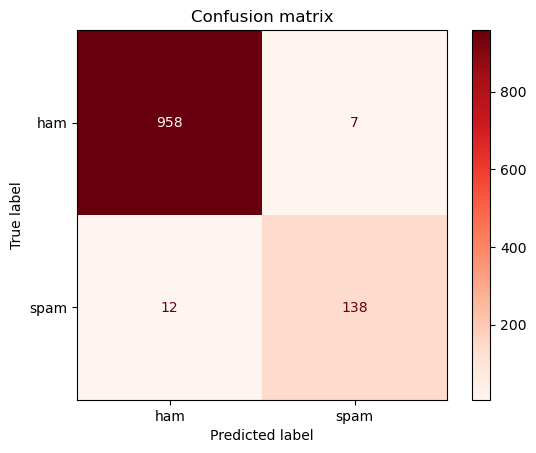

In [294]:
# Train the model using XGBoost
from xgboost import XGBClassifier

scale_pos_weight = total_negative_samples / total_positive_samples

xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, subsample=0.8, colsample_bytree=0.8, gamma=0.1, random_state=42)
xgb.fit(X_train, y_train.ravel())
y_pred = xgb.predict(X_test)

print('-' * 85)
print('                           XGBOOST CLASSIFIER MODEL')
print('-' * 85)
print(f'                            Accuracy score: {accuracy_score(y_test, y_pred)*100:.2f}%')
print('-' * 85)
print('Classification report:\n')
print(classification_report(y_test, y_pred))

conf_mtrx = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mtrx, display_labels=onehot.categories_[0])
disp.plot(cmap='Reds')
plt.title('Confusion matrix')
plt.show()

**Choosing XGBoost for Deployment**

For further deployment, XGBoost was selected not only for its **highest accuracy** among the models evaluated but also due to its **by far highest recall** rate. This means that XGBoost not only achieves impressive overall accuracy but also demonstrates a strong ability to correctly identify spam messages, making it well-suited for the task of spam detection where minimizing false negatives is crucial.


# **3. Model Deployment**



In [311]:
def predict_message(msg, allwords):
    """
    This function takes a message and predicts if it is spam or not.
    Parameters:
    msg : str : A message that needs to be predicted.
    Returns:
    prediction : str : A string that says if the message is spam or not.
    """
    msg = preproccess(msg)
    for word in msg.split():
        if word not in allwords:
            allwords.append(word)
    allwords_set = set(allwords)
    msg_df = pd.DataFrame(columns=list(allwords_set))
    msg_df.insert(0, 'label', [0])

    for word in msg.split():
        msg_df[word][0] = 1
    msg_df = msg_df.fillna(0)

    prediction = xgb.predict(msg_df.drop(["label"], axis=1))
    if prediction[0] == 0:
        return 'Message is NOT SPAM!'
    else:
        return 'Message is SPAM!'

In [312]:
spam = "Congratulations! You have been specially selected to receive special prize. To claim, call now."
not_spam = "Hey, how are you doing? I hope you're having a great day!"

print('-' * 85)
print(predict_message(spam, allwords))
print('-' * 85)
print(predict_message(not_spam, allwords))
print('-' * 85)

-------------------------------------------------------------------------------------
Message is SPAM!
-------------------------------------------------------------------------------------
Message is NOT SPAM!
-------------------------------------------------------------------------------------


**Model Performance Insights**

While the model has demonstrated **strong overall performance**, achieving an impressive accuracy of **98.30%** with the **XGBoost** classifier, it's worth noting that due to the **imbalanced nature** of the dataset, there are occasional **false-negative** predictions. This implies that despite the high accuracy, certain spam messages may not always be correctly identified.

The **precision** and **recall** metrics for both spam and non-spam classes are notably high, showcasing the model's effectiveness in distinguishing between spam and non-spam messages. However, the presence of occasional false negatives underscores the impact of class imbalance on model behavior.

Looking ahead, further refinement of the modeling approach could be beneficial to **minimize false negatives** and further enhance the model's ability to accurately predict spam messages.

